<a href="https://colab.research.google.com/github/23subbhashit/facial_expression_cnn/blob/master/face_expression_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Authorize Google Docs Access**

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'10fjGRRdhl23ITUdcu64wNG8k6Z6v8Ggp'}) 
downloaded.GetContentFile('resources.csv') 

# **Reading Data**

In [4]:
import pandas as pd
data1=pd.read_csv("resources.csv")
data1.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


# **Preprocessing**



In [36]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
image_size=(48,48)
 
def load_fer2013():
    data = pd.read_csv("resources.csv")
    pixels = data['pixels'].tolist()  
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).as_matrix()
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# **CNN Model**

In [0]:

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np

In [0]:
batch_size = 32
num_epochs = 110
input_shape = (48, 48, 1)
l2_regularization=0.01
data_generator = ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,zoom_range=.1,horizontal_flip=True)
regularization = l2(l2_regularization)

In [99]:
#initial
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
#1st phase
res= Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
res= BatchNormalization()(res)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, res])
 
#2nd phase
res= Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
res= BatchNormalization()(res)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, res])
 
#3rd phase
res= Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
res= BatchNormalization()(res)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, res])
 
#4th phase
res = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
res = BatchNormalization()(res)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, res])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 46, 46, 8)    72          input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_102 (BatchN (None, 46, 46, 8)    32          conv2d_55[0][0]                  
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 46, 46, 8)    0           batch_normalization_102[0][0]    
____________________________________________________________________________________________

# **Load Image**

In [0]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import imutils
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [26]:
from google.colab import files
f=files.upload()

Saving person2.jpg to person2.jpg


In [0]:
face_detection = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
EMOTIONS = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]

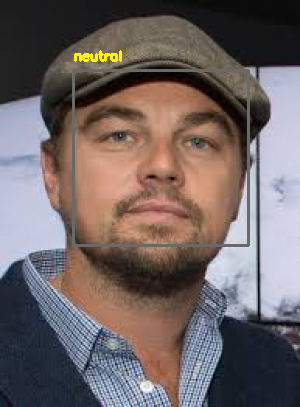

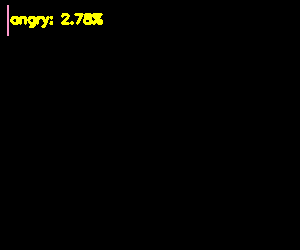

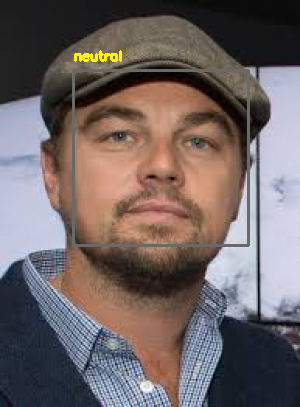

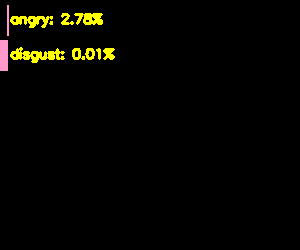

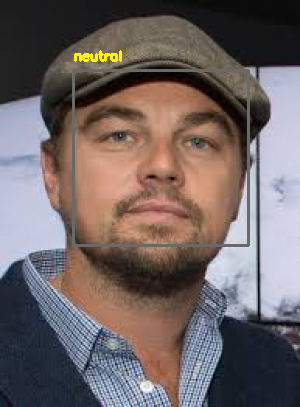

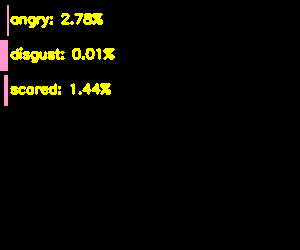

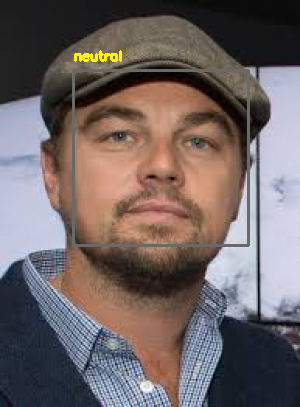

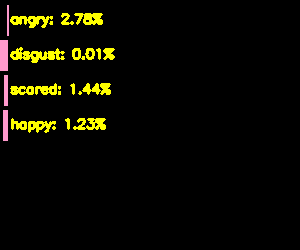

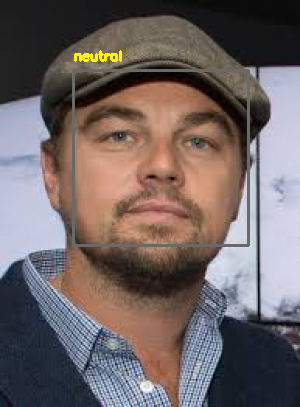

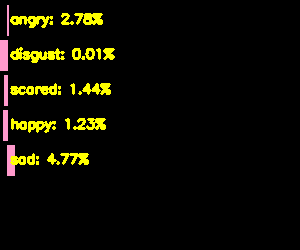

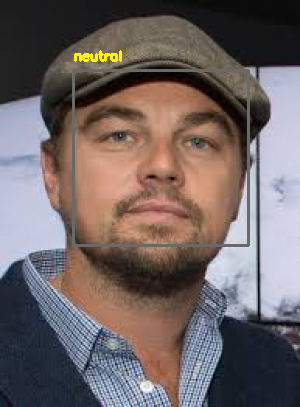

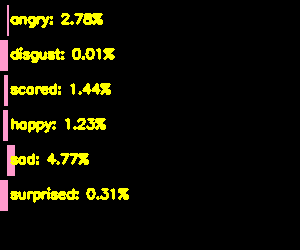

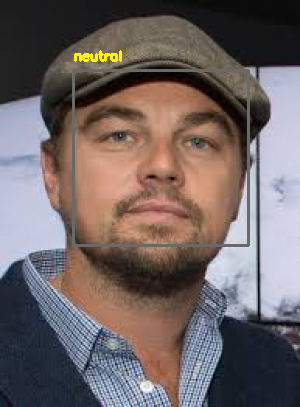

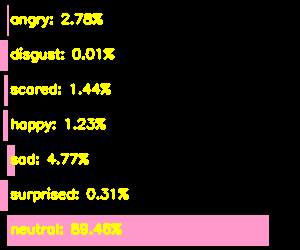

In [91]:
frame=cv2.imread("person2.jpg")
frame = imutils.resize(frame,width=300)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = face_detection.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
    
canvas = np.zeros((250, 300, 3), dtype="uint8")
frameClone = frame.copy()
if len(faces) > 0:
  faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
  (fX, fY, fW, fH) = faces
  roi = gray[fY:fY + fH, fX:fX + fW]
  roi = cv2.resize(roi, (64, 64))
  roi = roi.astype("float") / 255.0
  roi = img_to_array(roi)
  roi = np.expand_dims(roi, axis=0)
  preds = emotion_classifier.predict(roi)[0]
  emotion_probability = np.max(preds)
  label = EMOTIONS[preds.argmax()]
else:
  pass
for (i, (emotion, prob)) in enumerate(zip(EMOTIONS, preds)):
  text = "{}: {:.2f}%".format(emotion, prob * 100)
  w = int(prob * 300)
  cv2.rectangle(canvas, (7, (i * 35) + 5),(w, (i * 35) + 35), (204,153,255), -1)
  cv2.putText(canvas, text, (10, (i * 35) + 23),cv2.FONT_HERSHEY_SIMPLEX, 0.45,(0,255,255), 2)
  cv2.putText(frameClone, label, (fX, fY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,245,255), 2)
  cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH),(105,105,105), 2)
  cv2_imshow(frameClone)
  cv2_imshow(canvas)